In [1]:
import jax
import jax.numpy as jnp
import jax.tree_util as jtu
import numpy as np
import dataclasses
import matplotlib.pyplot as plt
import seaborn as sns
import genjax

sns.set_theme(style="white")

# Pretty printing.
console = genjax.pretty(width=80)

# Reproducibility.
key = jax.random.PRNGKey(314159)

The generative function interface exposes functionality which allows usage of generative functions for differentiable programming. These interfaces are designed to work seamlessly with `jax.grad` - allowing (even higher-order) gradient computations which are useful for inference algorithms which require gradients and gradient estimators. In this notebook, we'll describe some of these interfaces - as well as their (current, but not forever) limitations. We'll walk through an implementation of MAP estimation, as well as the Metropolis-adjusted Langevin algorithm (MALA) using these interfaces.

## Gradient interfaces

Because JAX features best-in-class support for higher-order AD, GenJAX exposes interfaces that compose natively with JAX's interfaces for gradients. The primary interface method which provides `jax.grad`-compatible functions from generative functions is an interface called `unzip`. 

`unzip` allows a user to provide a key, and a fixed choice map - and it returns a new key and two closures:

* The first closure is a "score" closure which accepts a choice map as the first argument, and arguments which match the non-`PRNGKey` signature types of the generative function. The score closure returns the exact joint score of the generative function. It computes the exact joint score using an interface called `assess`.^[Caveat: `assess` is not required to return the _exact_ joint score, only an estimate. However, if `jax.grad` is used on estimates - the resulting thing is not a correct gradient estimator. See the important callout below!]
* The second closure is a "retval" closure which accepts a choice map as the first argument, and arguments which match the non-`PRNGKey` signature types of the generative function. The retval closure executes the generative function constrained using the union of the fixed choice map, and the user provided choice map, and returns the return value of the execution. Here, the return value is also provided by invoking the `assess` interface.

So really, `unzip` is syntactic sugar over another interface called `assess`.

### `assess` for exact density evaluation

`assess` is a generative function interface method which computes log joint density estimates from generative functions. `assess` requires that a user provide a choice map _which completely fills all choices encountered during execution_. Otherwise, it errors.^[And these errors are thrown at JAX trace time, so you'll get an exception before runtime.]

If a generative function also draws from untraced randomness - `assess` computes an estimate whose expectation over the distribution of untraced randomness gives the correct log joint density. 

::: {.callout-important}

## Correctness of gradient estimators

When used on generative functions which include untraced randomness, naively applying `jax.grad` to the closures returned by interfaces described in this notebook **do not compute** gradient estimators which are unbiased with respect to the true gradients.

Short: don't use these with untraced randomness. We're working on alternatives.

:::

## A running example

Let's consider the following model, which we'll cover in different variations.

In [2]:
@genjax.gen
def model(key):
    key, x_mu = genjax.trace("x_mu", genjax.Uniform)(key, -3.0, 3.0)
    key, a = genjax.trace("a", genjax.Uniform)(key, -3.0, 3.0)
    key, b = genjax.trace("b", genjax.Uniform)(key, -3.0, 3.0)
    key, x = genjax.trace("x", genjax.Normal)(key, x_mu, 1.0)
    return genjax.trace("y", genjax.Normal)(key, a * x + b, 1.0)

Here's one neat trick - the `console = genjax.pretty()` exposes a function which can turn any `Jaxpr` into a graph.^[[Thank you  Niklas Schmitz](https://gist.github.com/niklasschmitz/559a1f717f3535db0e26d0edccad0b46).]

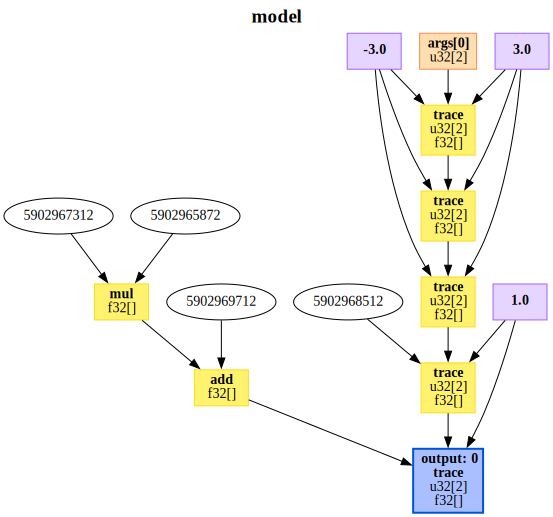

In [3]:
console.graph(model.source, key)

And, most importantly, visualizations.

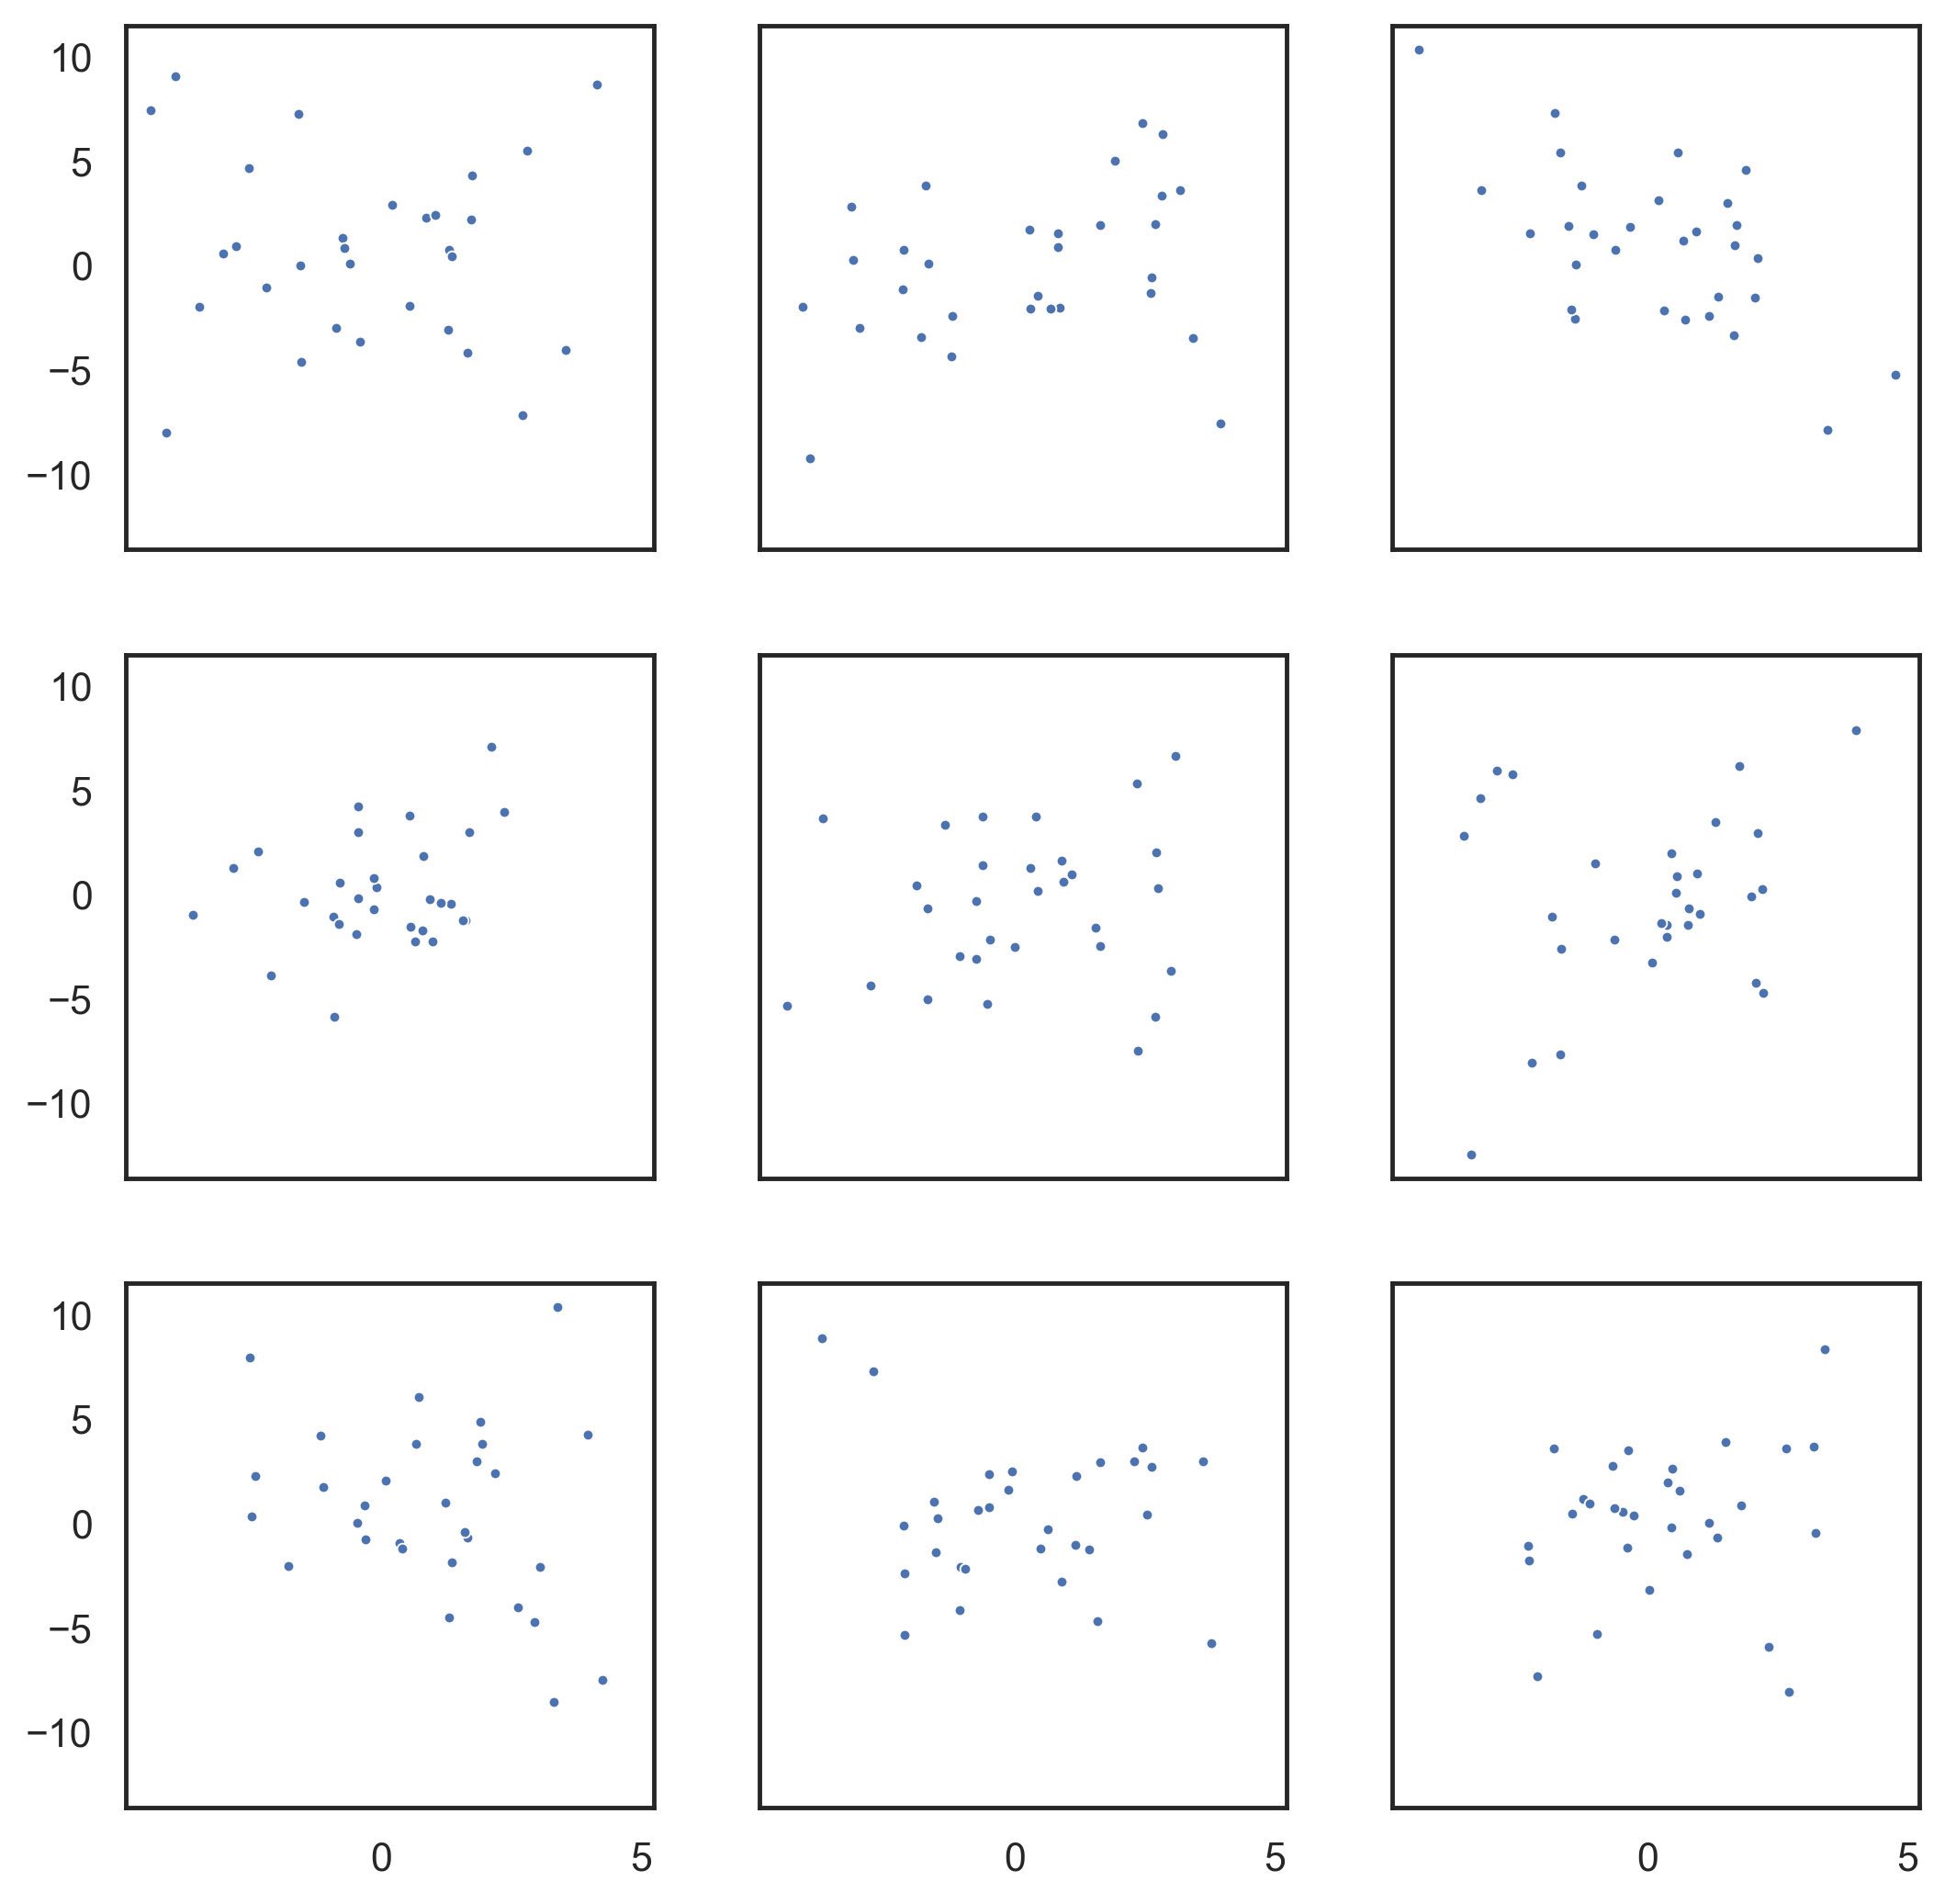

In [4]:
def viz(ax, x, y, **kwargs):
    sns.scatterplot(x=x, y=y, ax=ax, **kwargs)


f, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True, dpi=280)
jitted = jax.jit(jax.vmap(model.simulate, in_axes=(0, None)))
for ax in axes.flatten():
    key, *sub_keys = jax.random.split(key, 30 + 1)
    sub_keys = jnp.array(sub_keys)
    _, tr = jitted(sub_keys, ())
    x = tr["x"]
    y = tr["y"]
    viz(ax, x, y, marker=".")

plt.show()

A nice diffuse prior over points.

## MAP estimation

A good first step into the gradient waters is gradient-based maximum a posteriori probability (MAP) estimation. Here's how we write this in GenJAX:

In [5]:
@dataclasses.dataclass
class MapUpdate(genjax.Pytree):
    selection: genjax.Selection
    tau: genjax.Float

    def flatten(self):
        return (self.tau,), (self.selection,)

    def apply(self, key, trace):
        args = trace.get_args()
        gen_fn = trace.get_gen_fn()
        key, forward_gradient_trie = gen_fn.choice_grad(key, trace, selection)
        forward_values, _ = self.selection.filter(trace)
        forward_values = forward_values.strip()
        forward_values = jtu.tree_map(
            lambda v1, v2: v1 + self.tau * v2,
            forward_values,
            forward_gradient_trie,
        )
        key, (_, _, new_trace, _) = gen_fn.update(
            key, trace, forward_values, args
        )
        return key, (new_trace, True)

    def __call__(self, key, trace):
        return self.apply(key, trace)


map_update = MapUpdate

Simple, concise - works with any generative function whose addresses in `MapUpdate.selection` are modelled as continuous random variables.

From the `Pytree` interface, any instance of `MapUpdate` has a static `selection`, and a `tau` (which determines the gradient step size) which can be dynamic.

In inference code, we'd just construct `MapUpdate` before calling it.

In [6]:
update = map_update(genjax.select(["x_mu", "a", "b"]), 0.3)
update

MapUpdate
├── selection
│   └── BuiltinSelection
│       └── inner
│           └── HashableDict
│               ├── x_mu
│               │   └── AllSelection
│               ├── a
│               │   └── AllSelection
│               └── b
│                   └── AllSelection
└── tau
    └── (lit) 0.3

## Exposing learnable modules with `TrainCombinator`

For learning and variational inference, learnable parameters of model families are an important feature. In GenJAX, we expose a lightweight generative function wrapper around generative functions which accept `learnable_params` as a last argument - this wrapper is called `TrainCombinator`.

In [7]:
params = {"x_mu": 0.0, "a": 0.3, "b": 0.4}


@genjax.gen(genjax.TrainCombinator, params=params)
def model(key, params):
    x_mu = params["x_mu"]
    a = params["a"]
    b = params["b"]
    key, x = genjax.trace("x", genjax.Normal)(key, x_mu, 1.0)
    return genjax.trace("y", genjax.Normal)(key, a * x + b, 1.0)


model

TrainCombinator
├── inner
│   └── BuiltinGenerativeFunction
│       └── source
│           └── <function model>
└── params
    └── dict
        ├── x_mu
        │   └── (lit) 0.0
        ├── a
        │   └── (lit) 0.3
        └── b
            └── (lit) 0.4

`TrainCombinator` is a module-like abstraction which closes over the parameter store passed in and initialized by the constructor. When we call `TrainCombinator`, we don't need to provide the `params` argument - it's handled automatically.

In [8]:
key, tr = model.simulate(key, ())
tr

BuiltinTrace
├── gen_fn
│   └── BuiltinGenerativeFunction
│       └── source
│           └── <function model>
├── args
│   └── tuple
│       └── dict
│           ├── x_mu
│           │   └── (lit) 0.0
│           ├── a
│           │   └── (lit) 0.3
│           └── b
│               └── (lit) 0.4
├── retval
│   └── f32[]
├── choices
│   └── BuiltinChoiceMap
│       ├── x
│       │   └── DistributionTrace
│       │       ├── gen_fn
│       │       │   └── _Normal
│       │       ├── args
│       │       │   └── tuple
│       │       │       ├── (lit) 0.0
│       │       │       └── (lit) 1.0
│       │       ├── value
│       │       │   └── f32[]
│       │       └── score
│       │           └── f32[]
│       └── y
│           └── DistributionTrace
│               ├── gen_fn
│               │   └── _Normal
│               ├── args
│               │   └── tuple
│               │       ├── f32[]
│               │       └── (lit) 1.0
│               ├── value
│               │   └── f32[]
│               └── score
│                   └── f32[]
├── cache
│   └── BuiltinTrie
└── score
    └── f32[]

`TrainCombinator` exposes a convenient interface to a specialized scoring function which accepts `params` evaluation points, and returns the model logpdf.^[Note: because this interface method returns a **function**, we cannot JIT it. However, if we use it to produce a closure and then use that closure inside of code which we JIT, it's fine. As long as an object of **function** type doesn't try to escape across the JAX API boundary.]

In [9]:
key, logpdf = model.score_params(key, tr, params)
logpdf

Array(-2.23104, dtype=float32)

This interface supports batching out of the box.

In [10]:
key, *sub_keys = jax.random.split(key, 100 + 1)
sub_keys = jnp.array(sub_keys)
sub_keys, tr = jax.vmap(model.simulate)(sub_keys, ())
_, logpdf = jax.vmap(model.score_params, in_axes=(0, 0, None))(
    sub_keys, tr, params
)
logpdf

Array([-3.8144567, -2.815714 , -5.4926376, -2.8011963, -2.129803 ,
       -2.1409318, -3.1518354, -2.1439152, -5.4347057, -2.6018455,
       -3.1656373, -2.0671682, -2.4329953, -1.9971607, -2.575321 ,
       -4.7890406, -1.9236612, -4.565525 , -1.8850256, -2.3069606,
       -3.8633504, -2.6148465, -3.7199945, -2.1175876, -2.1262648,
       -2.054483 , -3.177068 , -3.0313969, -2.728084 , -2.2520533,
       -2.1975703, -2.2652159, -2.6274145, -4.6792316, -3.350772 ,
       -2.11759  , -1.8796927, -2.1535742, -2.9027162, -2.8021445,
       -1.8436316, -2.0109618, -3.2952006, -3.639164 , -3.4215667,
       -2.0921373, -2.396857 , -2.0932508, -2.1475265, -3.1193771,
       -3.8267322, -3.9804432, -2.4576356, -2.5622692, -2.6809855,
       -1.8537362, -3.1646593, -5.1409435, -2.4726286, -3.195097 ,
       -2.8336267, -4.175909 , -2.4823797, -2.3853517, -1.8488611,
       -1.8579401, -2.0236623, -2.1991177, -2.6226559, -2.2055511,
       -3.5278037, -2.8227391, -3.7910948, -1.999464 , -3.8187716,
       -2.493269 , -3.271794 , -7.0014133, -2.9179394, -1.9801328,
       -4.78782  , -2.0554748, -2.23625  , -2.8863544, -2.2097282,
       -1.893866 , -2.391351 , -4.4620266, -2.257174 , -2.0233703,
       -3.2778907, -2.0338364, -4.883012 , -2.1722562, -2.2235131,
       -6.0483575, -2.5019279, -3.7140136, -3.0524032, -3.1059947],      dtype=float32)

We make extensive use of batch evaluation in variational inference. For now, let's consider maximum likelihood learning and see the other `TrainCombinator` interfaces.

## Automatic differentiation variational inference

In this section, we'll show how we can use the gradient interfaces to implement [Automatic differentiation variational inference](https://arxiv.org/abs/1603.00788).